In [ ]:
pip install pyswarm

  Preparing metadata (setup.py) ... done
  Created wheel for pyswarm: filename=pyswarm-0.6-py3-none-any.whl size=4464 sha256=098253b6037c268850275062c5b0176c1436496a555af9c0e7b796fbbec1ebb0
  Stored in directory: /root/.cache/pip/wheels/71/67/40/62fa158f497f942277cbab8199b05cb61c571ab324e67ad0d6
Successfully built pyswarm


In [ ]:
#libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from pyswarm import pso
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Load the dataset
diabetes_data = pd.read_csv("/content/diabetes prediction.csv")
diabetes_data

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
# Split the dataset into features and target
X = diabetes_data.drop('Outcome', axis=1)
y = diabetes_data['Outcome']


In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# SVM
svm_model = SVC()
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)

In [ ]:
# Logistic Regression
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)

In [ ]:
# LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test)
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'verbosity': -1
}
lgb_model = lgb.train(params, lgb_train, num_boost_round=100)
lgb_pred = lgb_model.predict(X_test)
lgb_pred_binary = [1 if x >= 0.5 else 0 for x in lgb_pred]
lgb_accuracy = accuracy_score(y_test, lgb_pred_binary)

In [ ]:
import numpy as np

def objective_function(weights, X, y):
    weighted_sum = (weights[0] * np.array(svm_pred)) + (weights[1] * np.array(lr_pred)) + (weights[2] * np.array(lgb_pred_binary))
    weighted_sum_binary = [1 if x >= 0.5 else 0 for x in weighted_sum]
    return -accuracy_score(y, weighted_sum_binary)

lb = [0, 0, 0]
ub = [1, 1, 1]
weights, _ = pso(objective_function, lb, ub, args=(X_test, y_test))

Stopping search: maximum iterations reached --> 100


In [ ]:
# Weighted ensemble prediction
weighted_sum = (weights[0] * np.array(svm_pred)) + (weights[1] * np.array(lr_pred)) + (weights[2] * np.array(lgb_pred_binary))
weighted_sum_binary = [1 if x >= 0.5 else 0 for x in weighted_sum]
ensemble_accuracy = accuracy_score(y_test, weighted_sum_binary)

In [ ]:
print("SVM Accuracy:", svm_accuracy)
print("Logistic Regression Accuracy:", lr_accuracy)
print("LightGBM Accuracy:", lgb_accuracy)
print("Ensemble Accuracy (PSO-optimized):", ensemble_accuracy)

SVM Accuracy: 0.7337662337662337
Logistic Regression Accuracy: 0.7532467532467533
LightGBM Accuracy: 0.7077922077922078
Ensemble Accuracy (PSO-optimized): 0.7792207792207793


In [ ]:
accuracies = {
    'SVM': svm_accuracy,
    'Logistic Regression': lr_accuracy,
    'LightGBM': lgb_accuracy,
    'Ensemble (PSO-optimized)': ensemble_accuracy
}
best_model = max(accuracies, key=accuracies.get)
print("\nBest Model:", best_model, "with Accuracy:", accuracies[best_model])


Best Model: Ensemble (PSO-optimized) with Accuracy: 0.7792207792207793


In [ ]:
# Confusion matrices
plt.figure(figsize=(16, 12))

<Figure size 1600x1200 with 0 Axes>

<Figure size 1600x1200 with 0 Axes>

Text(50.722222222222214, 0.5, 'Actual')

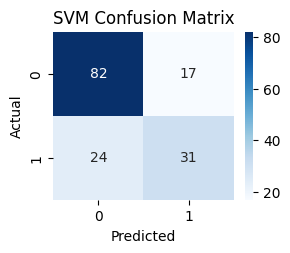

In [ ]:
plt.subplot(2, 2, 1)
svm_cm = confusion_matrix(y_test, svm_pred)
sns.heatmap(svm_cm, annot=True, fmt="d", cmap="Blues")
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

Text(321.26767676767673, 0.5, 'Actual')

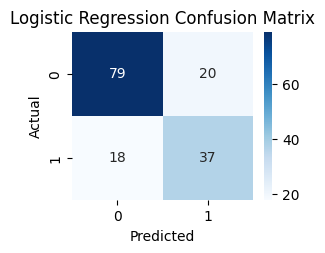

In [ ]:
plt.subplot(2, 2, 2)
lr_cm = confusion_matrix(y_test, lr_pred)
sns.heatmap(lr_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Logistic Regression Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

Text(50.722222222222214, 0.5, 'Actual')

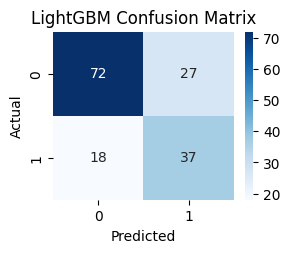

In [ ]:
plt.subplot(2, 2, 3)
lgb_cm = confusion_matrix(y_test, lgb_pred_binary)
sns.heatmap(lgb_cm, annot=True, fmt="d", cmap="Blues")
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

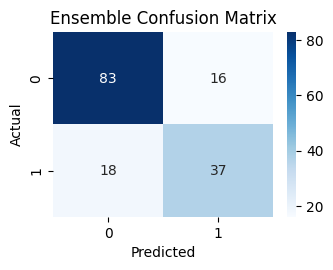

In [ ]:
plt.subplot(2, 2, 4)
ensemble_cm = confusion_matrix(y_test, weighted_sum_binary)
sns.heatmap(ensemble_cm, annot=True, fmt="d", cmap="Blues")
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

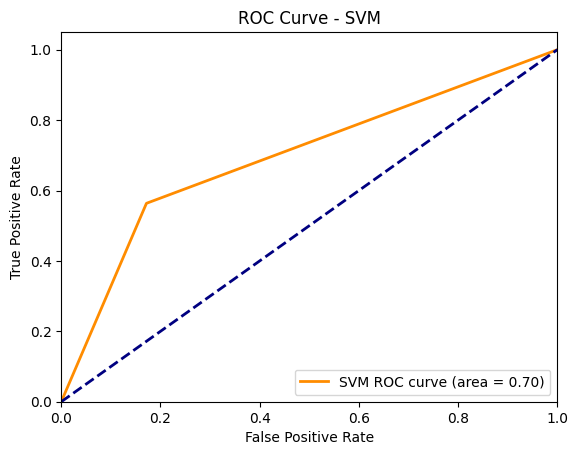

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc

# ROC Curve for SVM
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_pred)
svm_auc = auc(svm_fpr, svm_tpr)
plt.figure()
plt.plot(svm_fpr, svm_tpr, color='darkorange', lw=2, label='SVM ROC curve (area = %0.2f)' % svm_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - SVM')
plt.legend(loc="lower right")
plt.show()


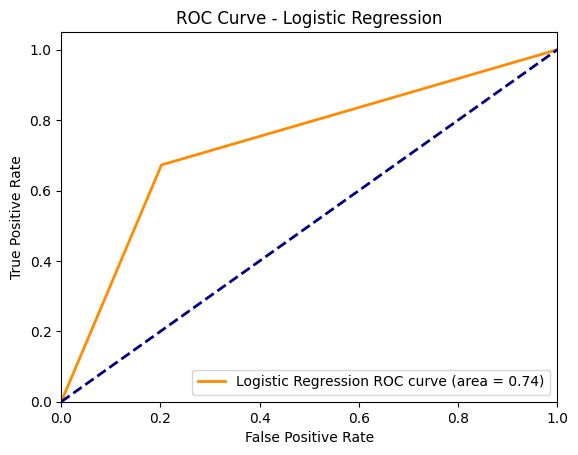

In [ ]:
# ROC Curve for Logistic Regression
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_pred)
lr_auc = auc(lr_fpr, lr_tpr)
plt.figure()
plt.plot(lr_fpr, lr_tpr, color='darkorange', lw=2, label='Logistic Regression ROC curve (area = %0.2f)' % lr_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc="lower right")
plt.show()


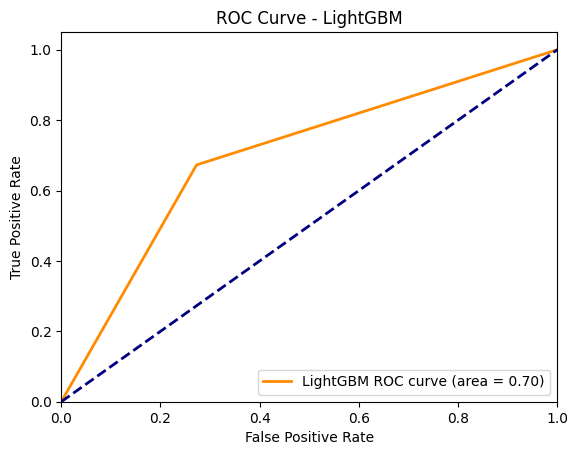

In [ ]:
# ROC Curve for LightGBM
lgb_fpr, lgb_tpr, _ = roc_curve(y_test, lgb_pred_binary)
lgb_auc = auc(lgb_fpr, lgb_tpr)
plt.figure()
plt.plot(lgb_fpr, lgb_tpr, color='darkorange', lw=2, label='LightGBM ROC curve (area = %0.2f)' % lgb_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend(loc="lower right")
plt.show()




In [ ]:
# Determining if the patient has diabetes or not
# Assuming a threshold of 0.5 for the ensemble prediction
diabetes_prediction = ["Diabetic" if x >= 0.5 else "Non-Diabetic" for x in weighted_sum]

In [ ]:
for i, prediction in enumerate(diabetes_prediction):
    print(f"Patient {i+1}: {prediction}")


Patient 1: Non-Diabetic
Patient 2: Non-Diabetic
Patient 3: Non-Diabetic
Patient 4: Non-Diabetic
Patient 5: Non-Diabetic
Patient 6: Non-Diabetic
Patient 7: Non-Diabetic
Patient 8: Diabetic
Patient 9: Diabetic
Patient 10: Diabetic
Patient 11: Non-Diabetic
Patient 12: Diabetic
Patient 13: Non-Diabetic
Patient 14: Non-Diabetic
Patient 15: Non-Diabetic
Patient 16: Non-Diabetic
Patient 17: Non-Diabetic
Patient 18: Non-Diabetic
Patient 19: Diabetic
Patient 20: Diabetic
Patient 21: Non-Diabetic
Patient 22: Non-Diabetic
Patient 23: Non-Diabetic
Patient 24: Non-Diabetic
Patient 25: Diabetic
Patient 26: Diabetic
Patient 27: Non-Diabetic
Patient 28: Non-Diabetic
Patient 29: Non-Diabetic
Patient 30: Non-Diabetic
Patient 31: Diabetic
Patient 32: Diabetic
Patient 33: Diabetic
Patient 34: Diabetic
Patient 35: Diabetic
Patient 36: Diabetic
Patient 37: Diabetic
Patient 38: Non-Diabetic
Patient 39: Non-Diabetic
Patient 40: Diabetic
Patient 41: Non-Diabetic
Patient 42: Non-Diabetic
Patient 43: Diabetic
Pa